In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Oct 19 21:16:20 2024

@author: Admin
"""

# -*- coding: utf-8 -*-
"""
Created on Sat Oct 19 20:38:19 2024

@author: Admin
"""

#!/usr/bin/env python
# coding: utf-8

# In[ ]:


#Claude ;double loop with sweeep function
#save file by IHLee



import pyvisa
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import re  # Regular expressions module
from datetime import datetime, timezone

# GPIB addresses
yokoid1 = "GPIB0::10::INSTR"
yokoid2 = "GPIB0::2::INSTR"
yokoid3 = "GPIB0::7::INSTR"
yokoid4 = "GPIB0::4::INSTR"
dmmid = "GPIB0::22::INSTR"

In [2]:
class Info:
    gname = None

In [3]:
# Function to open resource
def open_resource(resource_id):
    rm = pyvisa.ResourceManager()
    return rm.open_resource(resource_id)


# In[ ]:


def append_new_line(file_name, text_to_append):

    with open(file_name, "a+") as file_object:

        file_object.seek(0)

        data = file_object.read(100)

        if len(data) > 0:

            file_object.write("\n")

        file_object.write(text_to_append)





def append_multiple_lines(file_name, lines_to_append):

    with open(file_name, "a+") as file_object:

        appendEOL = False

        file_object.seek(0)

        data = file_object.read(100)

        if len(data) > 0:

            appendEOL = True

        for line in lines_to_append:

            if appendEOL == True:

                file_object.write("\n")

            else:

                appendEOL = True

            file_object.write(line)


# In[ ]:


# Function to read present voltage
def present_voltage(instrument):
    response = instrument.query("OD")
    match = re.search(r'([+-]?\d+\.\d+E[+-]\d+)', response)
    if match:
        return float(match.group(1))
    else:
        raise ValueError(f"Unexpected response format: {response}")
 


# In[ ]:


# Function to wind up voltage
def windup_voltage(instrument, start_voltage, step_size, delay):
    present_voltage_val = present_voltage(instrument)
    step_size = abs(step_size) if present_voltage_val < start_voltage else -abs(step_size)
    while abs(present_voltage_val - start_voltage) > abs(step_size) / 2:
        new_voltage = present_voltage_val + step_size
        new_voltage = start_voltage if (step_size > 0 and new_voltage > start_voltage) or (step_size < 0 and new_voltage < start_voltage) else new_voltage
        instrument.write(f"S{new_voltage:.6f}E")
        print(f"Wind-up voltage to: {new_voltage:.6f} V")
        time.sleep(delay)
        present_voltage_val = present_voltage(instrument)
    instrument.write(f"S{start_voltage:.6f}E")
    print(f"Final voltage set to: {start_voltage:.6f} V")


# In[ ]:


#modified from the original to save data

def sweep_V1(instrument, start_voltage, target_voltage, step_size, delay):
    present_voltage_val = start_voltage
    currents, voltages = [], []
    step_size = abs(step_size) if present_voltage_val < target_voltage else -abs(step_size)
    while abs(present_voltage_val - target_voltage) > abs(step_size) / 2:
        new_voltage = present_voltage_val + step_size
        new_voltage = target_voltage if (step_size > 0 and new_voltage > target_voltage) or (step_size < 0 and new_voltage < target_voltage) else new_voltage
        instrument.write(f"S{new_voltage:.6f}E")
        print(f"Sweeping voltage to: {new_voltage:.6f} V")
        time.sleep(delay)
        present_voltage_val = present_voltage(instrument)
        voltages.append(present_voltage_val)
        dmm = open_resource(dmmid)
        current = float(dmm.query("READ?"))
        currents.append(current)
       
        
        print(f"Multimeter: {current:.6f} A")
        plt.figure(figsize=(10, 6))
        plt.plot(voltages, currents, 'b-o')
        plt.title("Current vs Voltage")
        plt.xlabel("Voltage (V)")
        plt.ylabel("Current (A)")
        plt.grid(True)
        plt.show()
        plt.close()
        clear_output(wait=True)
        time.sleep(0.2)
    return voltages, currents

def sweep_V2(instrument, start_voltage, target_voltage, step_size, delay):
    present_voltage_val = start_voltage
    step_size = abs(step_size) if present_voltage_val < target_voltage else -abs(step_size)
    while abs(present_voltage_val - target_voltage) > abs(step_size) / 2:
        new_voltage = present_voltage_val + step_size
        new_voltage = target_voltage if (step_size > 0 and new_voltage > target_voltage) or (step_size < 0 and new_voltage < target_voltage) else new_voltage
        instrument.write(f"S{new_voltage:.6f}E")
        print(f"Setting V2 to: {new_voltage:.6f} V")
        time.sleep(delay)
        present_voltage_val = present_voltage(instrument)

    
#def sweep_V1_for_fixed_V2(instrument1, instrument2, V1_start, V1_end, V1_step, V2_value, delay):
#    sweep_V2(instrument2, present_voltage(instrument2), V2_value, V1_step, delay)
#    print(f"V2 fixed at: {V2_value:.6f} V")
#    return sweep_V1(instrument1, V1_start, V1_end, V1_step, delay)

def sweep_V1_for_fixed_V2(instrument1, instrument2, V1_start, V1_end, V1_step, V2_value,V2_step, delay):
    sweep_V2(instrument2, present_voltage(instrument2), V2_value, V2_step, delay)
    print(f"V2 fixed at: {V2_value:.6f} V")
    return sweep_V1(instrument1, V1_start, V1_end, V1_step, delay)


# In[7]:


#double loop confirmed ;Claude created
#append_multiple_lines called to save

In [4]:
def main(jter):
    instrument1 = open_resource(yokoid4) #scan #Q2
    instrument2 = open_resource(yokoid1) #step  #tr
    instrument3 = open_resource(yokoid3) #sd
    #instrument4 = open_resource(yokoid2) #
    #instrument5 = open_resource(yokoid5) #pl
    
    start_voltage1, step_size1, delay1 = 0, 0.05, 0.2 #Q2
    start_voltage2, step_size2, delay2 = 0.3, 0.05, 0.2 #TR
    start_voltage3, step_size3, delay3 = 0.2, 0.01, 0.05 #sd
    #start_voltage4, step_size4, delay4 = 0.1, 0.05, 0.1  #
    #start_voltage5, step_size5, delay5 = 0.0, 0.05, 0.1  #pl
    
    target_voltage1, step_size0, delay0 = -1, 0.005, 0.2  #Q2
    target_voltage2, step_size02, delay02 = 0.5, 0.001, 0.2 #TR
    
    windup_voltage(instrument1, start_voltage1, step_size1, delay1)
    windup_voltage(instrument2, start_voltage2, step_size2, delay2)
    windup_voltage(instrument3, start_voltage3, step_size3, delay3) 
    #windup_voltage(instrument4, start_voltage4, step_size4, delay4)
    #windup_voltage(instrument5, start_voltage5, step_size5, delay5) 
    
    
    voltage1 = present_voltage(instrument1)
    voltage2 = present_voltage(instrument2)
    print(f"Starter voltage1: {voltage1:.6f} V")
    print(f"Starter voltage2: {voltage2:.6f} V")
    
   
    V2_values = np.arange(start_voltage2, target_voltage2, step_size02)


    all_results = []
    print(all_results )

 
        
    for V2 in V2_values:
        print(f"\nSweeping V1 with V2 fixed at {V2:.2f} V")
        #voltages, currents = sweep_V1_for_fixed_V2(instrument1, instrument2, start_voltage1, target_voltage1, step_size0, V2, delay1)
        voltages, currents = sweep_V1_for_fixed_V2(instrument1, instrument2, start_voltage1, target_voltage1, step_size0, V2,step_size02, delay1)
        windup_voltage(instrument1, start_voltage1, step_size1, delay1)
        all_results.append((V2, voltages, currents))

    # Save data to file
    #fname = 'xxxdata_IVg_0x3-0x5TR_0x2mVsd_4K_202502101154.txt'
    gname = 'data_iv_'+str(jter)+'.txt'
    #utc_now = datetime.now(timezone.utc)
    #gname = 'data_iv_'+str(jter)+'_'+utc_now.isoformat()+'_'+'.txt'
    lines_to_append = []
    for V2, voltages, currents in all_results:
        for v, i in zip(voltages, currents):
            line = f"{V2:.6f} {v:.6f} {i:.6f}"
            lines_to_append.append(line)
    append_multiple_lines(gname, lines_to_append)
    
    # Plot all results
    plt.figure(figsize=(12, 8))
    for V2, voltages, currents in all_results:
        plt.plot(voltages, currents, '-o', label=f'V2 = {V2:.2f} V')
    
    plt.title("xxxI vs V_ENTu for V_ENTd, V_TR=350 mV")
    plt.xlabel("V_ENT (V)")
    plt.ylabel("Current (10 nA)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    voltage_target = present_voltage(instrument1)
    print(f"Target voltage: {voltage_target:.6f} V")
    dmm = open_resource(dmmid)
    current = float(dmm.query("READ?"))
    print(f"Multimeter: {current:.6f} A")
    voltage2 = present_voltage(instrument2)
    print(f"Starter voltage2: {voltage2:.6f} V")

Sweeping voltage to: -0.550000 V
Multimeter: 0.000472 A


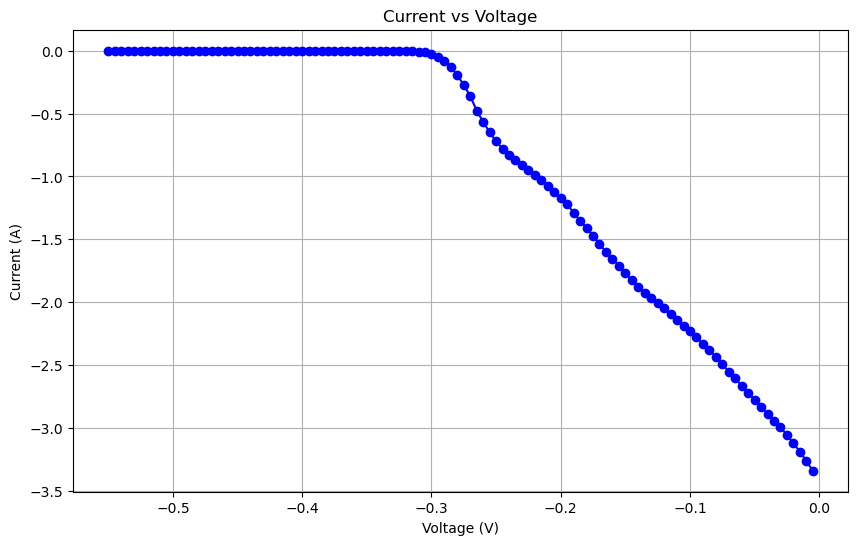

In [ ]:
for jter in range(11):
    main(jter)